<img style="float: left;" src="D2Klogo.png" width="20%"> 

<center>

# Welcome to DSCI 101 #
### Introduction to Data Science ###    
### A Case Study from DSCI 101 Spring 2022 Cohort ###
    
- Contributors: Andrea Arellano, Kenny Nguyen, Matthew Edelstein, Tre’shon Devones, Audrey Connell
- Case study notebook developped by Su Chen

<h1><center>Criminal Minds: Visualizing Trends in Crime using Houston Police Department Reports 2019 - 2021</center></h1>    


# Introduction
The majority of our group is from outside of Houston, and we wanted to know about the safety of the area surrounding Rice, as well as other areas within Houston. We wanted to know what types of crime are prevalent in different areas of Houston and how the frequency of different types of crime and their location changed pre and post-pandemic. Since we reside in Houston, this project is relevant to our safety and well-being; as it currently stands, the Rice University Police Department will send out alerts when there is a nearby threat, but we are often unaware of the threats and dangers outside the bounds of Rice Village. Fortunately, the Houston Police Department collects and posts data every year regarding crimes, including a plethora of details from each crime report. 

In [75]:
### standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# allows you to view the plots upon executing your code
%matplotlib inline
# sets the plotting style, feel free to change!
plt.style.use('fivethirtyeight')
# prevents histogram bars to fuse together
plt.rcParams["patch.force_edgecolor"] = True
import seaborn as sns
import warnings
# ignores warning message
warnings.filterwarnings('ignore')
# sets figure size
plt.rcParams["figure.figsize"] = (10,8)

##  Read data, create dataframes, and clean data

We combined three data sets for this project: the crime reports from 2019, 2020, and 2021. These data sets consist of every reported crime during the given calendar year; each row represents a single reported crime. The original dataset consisted of one date column in the form of MM/DD/YYYY. We engineered features to separate the day, month, and year into individual columns to allow more precise organization and searching. Each row lists the occurrence date, time, and ZIP Code, as well as the type of crime committed, who it was committed against, and many other variables. A full list of variables are described in the Appendix. 

Before EDA, we cleaned the data by renaming some of the columns and entries to more simple and understandable versions. Many entries had crime category and premise names that we made more concise. ZIP Codes sometimes consisted of an extra 4 digits that represent the delivery route, so we standardized them to only include the first 5 digits listed. 

Our dataset consisted of very few numerical variables: the day (1-31), month, year, offense count, hour of occurrence, and incident number (which is only useful for identifying specific cases within the department). Within this small list of numerical variables, not many are useful for finding applicable and relevant trends; for example, the offense count is almost always 1, which provides no insight. The vast majority of our analysis involving numerical variables used the occurrence date (day, month, or year) or time. 


In [76]:
houston_crime = pd.read_csv('2019_2021_NIBRSPublicView.csv')
# prints out column names
print(houston_crime.columns)
# replaces old columns names with more informative names
houston_crime.rename(columns={'RMSOccurrenceDate': 'Occurrence Date', 'RMSOccurrenceHour' :'Occurrence Hour','NIBRSClass':'Class','NIBRSCategory':'Category','NIBRSDescription':'Description','NIBRSCrimeAgainst':'Crime Against','OffenseCount':'Offense Count'},inplace=True)
# checks the number of rows and columns in the dataframe
print(houston_crime.shape)
print('')
# checks data type for each column
print(houston_crime.dtypes)
print('')
# checks for missing values in each column
houston_crime.isna().sum(axis = 0)

Index(['Incident', 'RMSOccurrenceDate', 'RMSOccurrenceHour', 'NIBRSClass',
       'NIBRSCategory', 'NIBRSDescription', 'NIBRSCrimeAgainst',
       'OffenseCount', 'Beat', 'Premise', 'StreetNo', 'StreetName',
       'StreetType', 'Suffix', 'City', 'ZIPCode'],
      dtype='object')
(713924, 16)

Incident            int64
Occurrence Date    object
Occurrence Hour     int64
Class              object
Category           object
Description        object
Crime Against      object
Offense Count       int64
Beat               object
Premise            object
StreetNo           object
StreetName         object
StreetType         object
Suffix             object
City               object
ZIPCode            object
dtype: object



Incident                0
Occurrence Date         0
Occurrence Hour         0
Class                   0
Category                0
Description             0
Crime Against           0
Offense Count           0
Beat                  481
Premise                 1
StreetNo             2137
StreetName              0
StreetType          56173
Suffix             610549
City                    0
ZIPCode              8299
dtype: int64

In [77]:
# separates 'Occurrence Date' into substrings
# adds new 'Month' and 'Year' columns to dataframe
sep_date = houston_crime['Occurrence Date'].str.split(pat="/", expand=True)
houston_crime['Month'] = sep_date[0].astype(int)
houston_crime['Day'] = sep_date[1].astype(int)
houston_crime['Year'] = sep_date[2].astype(int)
houston_crime['Year'] = houston_crime['Year'] + 2000
# converts original 'Occurrence Date' string argument to datetime object
# converting makes it easier to manipulate date in later analysis
houston_crime['Occurrence Date'] = pd.to_datetime(houston_crime['Occurrence Date'])

In [78]:
# designates a day of the year to a specific number corresponding to the day of the year
previous_days = {1:0, 2:31, 3:59, 4:90, 5:120, 6:151, 7:181, 8:212, 9:243, 10:273, 11:304, 12:334}

day_of_year = []
for (month, day) in zip(houston_crime['Month'],houston_crime['Day']):
  doy = day + previous_days[month]
  day_of_year.append(doy)

houston_crime['Day of Year'] = day_of_year

In [79]:
# cleans up the Category column
crime_cat_dict = {'Theft Offenses':'Theft', 'Assault Offenses':'Assault', 'Fraud Offenses':'Fraud',
                  'Destruction/Damage/Vandalism of Property':'Destruction of Property', 'Drug/Narcotic Offenses':'Drug Offenses', 
                  'Burglary/Breaking & Entering':'Burglary', 'Curfew/Loitering/Vagrancy Violations':'Curfew Violations', 
                  'Extorsion/Blackmail':'Blackmail', 'Pornography/Obscene Material':'Pornography',
                  'Counterfeiting/Forgery':'Forgery','Family Offenses, Nonviolent': 'Family Offenses',
                  'Larceny/Theft Offenses': 'Theft Offenses', 'Sex Offenses, Forcible': 'Sex Offenses', 
                  'Sex Offenses, Nonforcible':'Sex Offenses', 'Trespass of Real Property':'Trespass',
                  'Driving Under the Influence': 'DUI'}
houston_crime['Category'] = houston_crime['Category'].replace(crime_cat_dict)

In [80]:
# cleans up the Premise column
crime_premise_dict = {'Residence, Home (Includes Apartment)':'Residence', 'Parking Lot, Garage':'Parking Lot', 
                      'Highway, Road, Street, Alley':'Highway, Street', 'Other, Unknown':'Other', 'Department, Discount Store':'Store',
                      'Convenience Store':'Store', 'Commercial, Office Building':'Commercial Building', 'Restaurant':'Restuarant', 
                      'Service, Gas Station':'Service Station', 'Hotel, Motel, ETC':'Hotel, Motel', 'Speciality Store':'Store',
                      'Grocery, Supermarket':'Supermarket', 'Drug Store, Doctors Office, Hospital':'Doctors, Hospital',
                      'Bar, Nightclub':'Bar, Nightclub', 'Airplane, Bus,Train Terminal':'Airplane, Bus, Train', 'Park/Playground':'Park',
                      'Shopping Mall':'Mall', 'Rental Storage Facility':'Storage', 'Bank, Savings & Loan':'Bank', 
                      'Government, Public Building':'Public Building', 'Construction Site':'Construction Site', 'Auto Dealership New/Used':'Auto Dealership',
                      'Church, Synagogue, Temple':'Religious Building', 'School-Elementary/Secondary':'School', 'Field, Woods':'Outdoors',
                      'Liquor Store':'Store', 'Cyberspace':'Cyberspace', 'Arena/Stadium/Fairgrounds/Coliseum':'Arena', 'Industrial Site':'Construction Site',
                      'ATM Separate from Bank':'Bank', 'Daycare Facility':'Daycare', 'Community Center':'Community Center', 'Shelter-Mission/Homeless':'Outdoors',
                      'Jail, Prison':'Jail, Prison', 'Abandoned/Condemned Structure':'Abandoned Structure', 'School-College/University':'School', 
                      'Gambling Facility/Casino/Race Track':'Other', 'Amusement Park':'Other', 'Rest Area':'Service Station', 
                      'Dock/Wharf/Freight/Modal Terminal':'Dock', 'Farm Facility':'Farm', 'Lake, Waterway':'Outdoors', 'Camp/Campground':'Outdoors',
                      'School, College':'School', 'Military Installation':'Other', 'Tribal Lands':'Other'}
houston_crime['Premise'] = houston_crime['Premise'].replace(crime_premise_dict)

In [81]:
# separates 'ZIPCode' into substrings
# adds new column 'NewZIPCode' consiting of only the first 5 digits of each old ZIP code to data frame
sep_zip = houston_crime['ZIPCode'].str.split(pat="-", expand=True)
# sep_zip = sep_zip.drop(columns=[1]).dropna()
houston_crime['NewZIPCode'] = sep_zip[0]

In [82]:
# print out cleaned up dataframe
houston_crime.head()

Incident Occurrence Date  Occurrence Hour Class                 Category  \
0      5619      2019-01-01                0   290  Destruction of Property   
1     17319      2019-01-01                0   35A            Drug Offenses   
2     18119      2019-01-01                0   290  Destruction of Property   
3     19019      2019-01-01                0   520    Weapon Law Violations   
4     20519      2019-01-01                0   13A                  Assault   

                      Description Crime Against  Offense Count   Beat  \
0  Destruction, damage, vandalism      Property              1   9C30   
1       Drug, narcotic violations       Society              1   7C10   
2  Destruction, damage, vandalism      Property              1  16E40   
3           Weapon law violations       Society              1    NaN   
4              Aggravated Assault        Person              1  15E30   

           Premise  ...  StreetName StreetType Suffix     City     ZIPCode  \
0        Residence  ...  SAN CARLOS        NaN    NaN  HOUSTON       77013   
1  Highway, Street  ...        EAST        FWY    NaN  HOUSTON       77020   
2        Residence  ...  LONE QUAIL         CT    NaN  HOUSTON       77489   
3        Residence  ...   MELBOURNE        NaN    NaN  HOUSTON  77026-0000   
4        Residence  ...        OSBY         DR    NaN  HOUSTON       77025   

  Month  Day  Year  Day of Year  NewZIPCode  
0     1    1  2019            1       77013  
1     1    1  2019            1       77020  
2     1    1  2019            1       77489  
3     1    1  2019            1       77026  
4     1    1  2019            1       77025  

[5 rows x 21 columns]

## Exploratory Data Analysis

### EDA - Univariate Analysis

Our univariate analysis mostly looks at the distribution of crime counts based on the premises, types of crime, ZIP Codes, and against whom the crime was committed (property, person, or society). Some visualizations combined all 3 years, while others isolated a specific year. 

We also constructed a function that displays the crime count distribution of a chosen variable from either a specific year or all years combined; the bar graphs are then arranged in descending order, and only a chosen number, n, of the most common entries are shown. Additionally, we built a function that shows the count distribution of the top 10 most common types of crime within a chosen time frame. In most of our univariate analysis, there was an exponential decline in the distribution of counts; the count of crimes by ZIP Code is somewhat linear except for one area with vastly more crime reports than any other. 

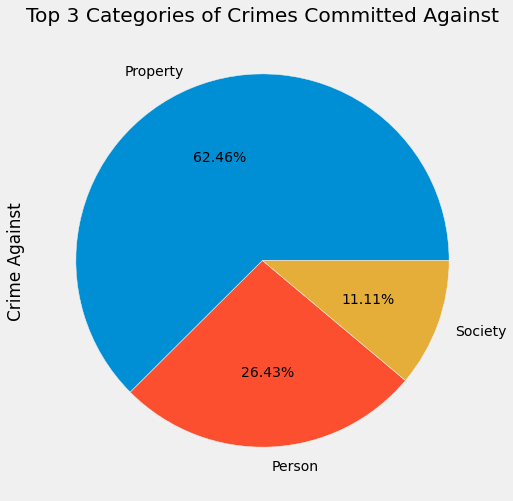

In [83]:
crime_against = houston_crime['Crime Against'].value_counts()
# creates a pie plot for crime against top 3 categories
crime_against.head(3).plot(kind='pie', autopct='%1.2f%%', title='Top 3 Categories of Crimes Committed Against');

In [114]:
# We want to check the value counts and percentage 
# for several different columns so we created a function
# Functions takes a column and returns the values count for said columns
def columns_count_func(df=houston_crime, column_name='Category'):
  '''
  Finds the value count and percentage for a given categorical column.
  '''
  # value_counts returns series by default, convert to df
  output_df = pd.DataFrame(df[column_name].value_counts()).reset_index()
  # rename column names to be informative
  output_df.columns = [column_name, 'Count']
  # add column to calculate percentage from counts
  output_df['Percent'] = round(output_df['Count']/len(df)*100,0)
  return output_df

In [149]:
# counts the number of crimes in houston and houston suburbs
columns_count_func(column_name='City')
# Value counts for each crime category
columns_count_func(column_name='Category')
# Value counts for each premise
columns_count_func(column_name='Premise')
# counts the number of crimes that occur at each street
columns_count_func(column_name='StreetName')
# Counts the number of crimes by zipcode
columns_count_func(column_name='NewZIPCode')

NewZIPCode  Count  Percent
0        77036  25907      4.0
1        77092  15398      2.0
2        77004  15148      2.0
3        77063  14737      2.0
4        77021  14401      2.0
..         ...    ...      ...
223      70514      1      0.0
224      98004      1      0.0
225      77354      1      0.0
226      75234      1      0.0
227      78666      1      0.0

[228 rows x 3 columns]

Insights generated:
- 99% of crimes are in city of Houston, other suburbs only counts as 1%.
- 29% of crimes are theft and 24% are assault.
- 38% of crimes are in residence, 18% in parking lot and 15% on the highways.
- WESTHEIMER is the street name with the most crimes, about 3%, any other strees are no more than 1%.
- 77036 is the zipcode with the most crimes, about 4%, any other zipcodes are no more than 2%.

In [134]:
# Creates a plot for the top 10 crime counts in a given time frame
def top_crimes_timeframe(df=houston_crime, column='Category', 
                         start_date='2019-01-01', end_date='2020-01-01', 
                         top_n_crimes=5, plot_color='blue'):
  '''
  Finds the top n crimes in a given time frame.
  '''
  new_df = df.set_index('Occurrence Date').loc[start_date:end_date]
  plot_df = new_df[column].value_counts().head(top_n_crimes)
  plot_df.plot(kind='bar', rot=45, color=plot_color, title='Top ' + str(top_n_crimes) + ' Crimes from ' + start_date + ' to ' + end_date);

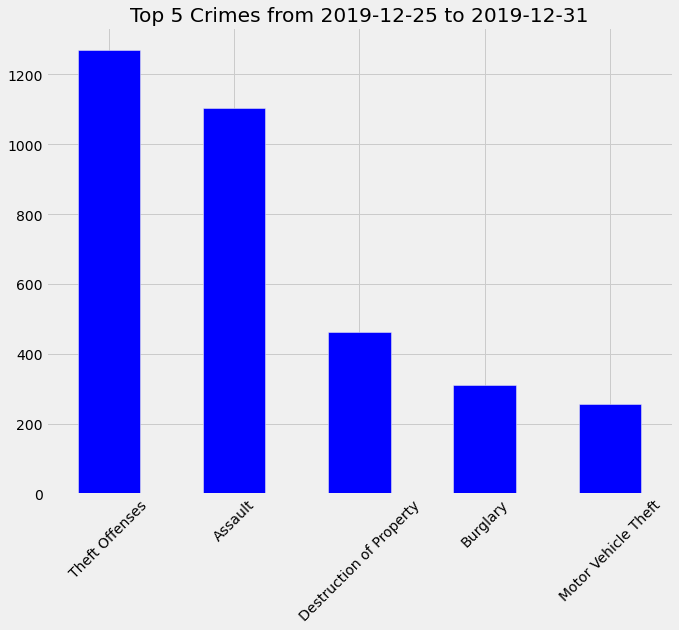

In [136]:
# Top 10 crimes from December 25, 2019 to December 31, 2019
top_crimes_timeframe(column='Category', start_date='2019-12-25', end_date='2020-01-01');

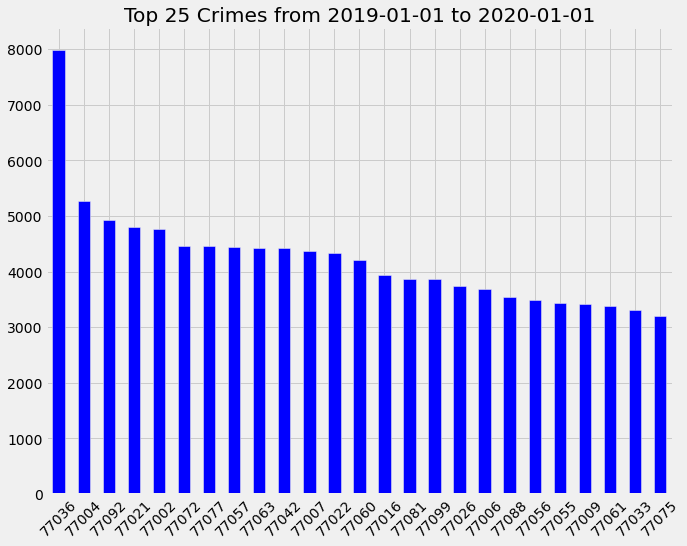

In [148]:
# creates a bar plot for top 25 zip codes with the most number of crimes
top_crimes_timeframe(column='NewZIPCode', start_date='2019-01-01', end_date='2020-01-01', top_n_crimes=25);

### EDA - Bivariate Analysis

We explored the relationships and trends of crime counts between the types of crime (category) and the premise, police beat, month, and year: each in individual visualizations. We produced a 3-line lineplot (one line for each year) showing the count of all crimes for each month throughout the year. In this visualization, we were able to see that the line plot for 2019 is consistently below that of 2020 and 2021. Additionally, we created a function that displays a 3-line lineplot showing the count of a specific type of crime (or all crime combined) either for each hour throughout the day or for each day throughout the year. This helps us compare the timing of crimes before, during, and somewhat after the pandemic. 

In [189]:
# creates a lineplot with three lines (2019, 2020, and 2021) for the number of a given crime by day or hour
def crime_by_hour(df=houston_crime, type_of_crime='all', by='Hour'):
  '''
  Creates a lineplot of three lines for the years 2019, 2020, and 2021 
  for the number of a given type of crime for 
  each hour of the day, day of the year, or month
  '''
  if type_of_crime == 'all':
    df = houston_crime
  else:
    df = df[df['Category']==type_of_crime]
  if by == 'Hour':
    idx="Occurrence Hour"
  if by == 'Day':
    idx="Day of Year"
  if by == 'Month':
    idx="Month"
  crime_type_year = df.pivot_table(index=idx, columns="Year", values="Incident", aggfunc="count")
  plot = crime_type_year.plot(title='Number of ' + type_of_crime + ' Crimes by ' + by, alpha=0.5);
  return plot

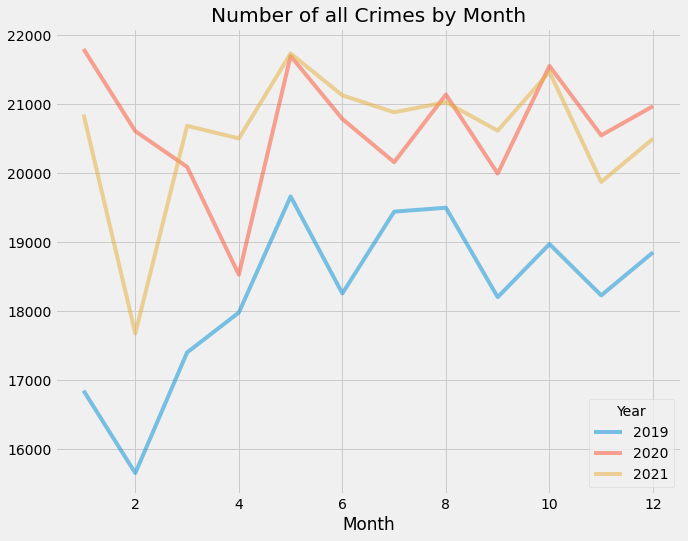

In [190]:
# creates a lineplot with three lines (2019, 2020, and 2021) for the number of all crimes by month
crime_by_hour(type_of_crime='all', by='Month');

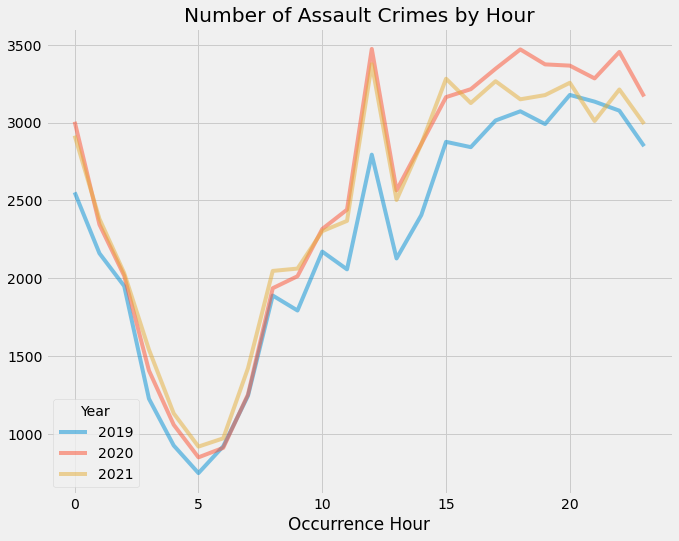

In [191]:
# creates a lineplot with three lines (2019, 2020, and 2021) for the number of assault crimes by hour
crime_by_hour(type_of_crime='Assault', by='Hour');

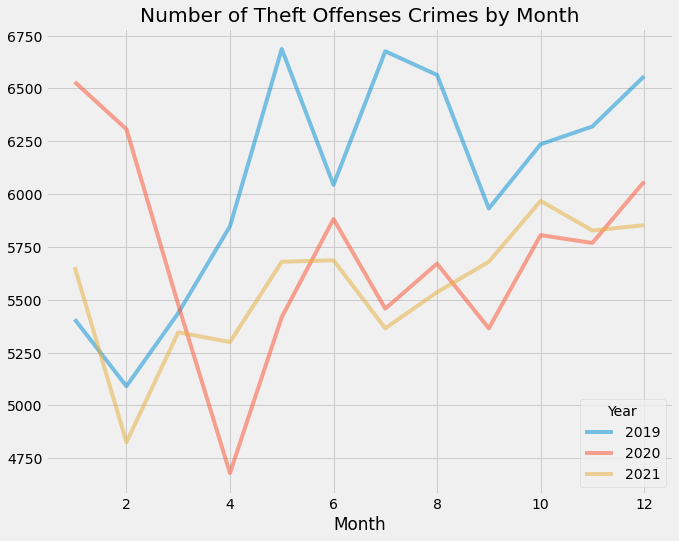

In [192]:
# creates a lineplot with three lines (2019, 2020, and 2021) for the number of theft offense crimes by month
crime_by_hour(type_of_crime='Theft Offenses', by='Month');

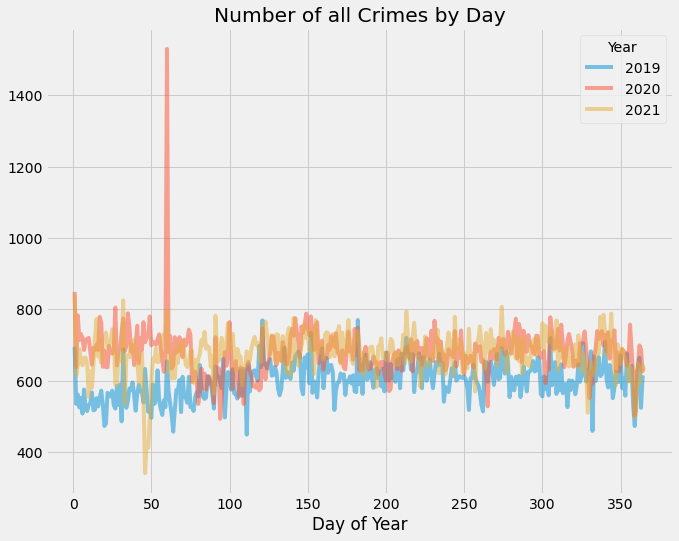

In [193]:
# creates a lineplot with three lines (2019, 2020, and 2021) for the number of theft offense crimes by day
crime_by_hour(type_of_crime='all', by='Day');

In [194]:
# look into the number of crime for the peak in 2020
df = houston_crime.pivot_table(index="Day of Year", columns="Year", values="Incident", aggfunc="count")
df[55:65]

Year         2019  2020  2021
Day of Year                  
56            521   691   671
57            504   662   722
58            545   625   730
59            526   686   733
60            654  1530   797
61            570   680   625
62            538   726   652
63            504   634   606
64            457   643   669
65            518   722   607

### Findings

Thus far through univariate and bivariate analysis we have increased our comprehension of the dataset. We found that from 2019 to 2021, the two most common crimes in Houston, by far, were consistenly Assault and Larceny/Theft offenses. We also found that the ZIP Code 77036 has about ten thousand more offenses than the next leading ZIP Code, so it's worth looking into and hypothesizing why that is the case. We also found that Westheimer street has almost double the number of offenses than the next leading street, so that is also worth some consideration and exploration. More specifically, we can look into the most common crimes within the aformentioned ZIP Code and street.

We also looked into the peak of total crime by day in 2020: it seems the day 60 has twice as many crimes as an average day during the year. We later discovered this was due to the incorrect calculation ignoring the leap year of 2020, so day 60 included number of crimes in both 2/28/2020 and 2/29/2020 combined. 

### EDA - Spatial Analysis

Lastly, we used a heat map function to visualize specific crimes on a map of Houston divided by ZIP Code. The function visualizes the count, within each area, of a specific type of crime in a given year by color, with a darker color corresponding to a higher count. The heat map function can be used to show where certain types of crime are more prevalent, as well as how the frequency of different types of crime have changed across areas of Houston from before and throughout the pandemic. 

In [195]:
# folium to create Houston map 
!pip install folium
import folium

# look up month in string based on integer
month_dict={1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
            7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December' }

In [199]:
def map_crime_by_zip(df=houston_crime, crime_city='HOUSTON', crime_year=19, crime_month=1, crime_type='Burglary'):
  '''this function creats a map for number of crimes by zipcode in Houston
    can filter on year, month and a particular crime category 
  '''
  df = df[df['City']==crime_city]
  df = df[df['Year']==crime_year]
  df = df[df['Month']==crime_month]
  df = df[df['Category']==crime_type]

  crime_by_zip = df.pivot_table(index='NewZIPCode', columns='Year', values='Incident', aggfunc='count', fill_value=0)
  crime_by_zip.reset_index(inplace=True)
  crime_by_zip['NewZIPCode'] = crime_by_zip['NewZIPCode'].astype(int)

  map = folium.Map(location=[29.749907, -95.358421]) # this is lat and lon for Houston
  map.choropleth(geo_data='Zip_Codes.geojson', # geojson file downloaded here: https://cohgis-mycity.opendata.arcgis.com/datasets/MyCity::zip-codes/about
             data=crime_by_zip, # my dataset
             columns=['NewZIPCode', crime_year], # zip code is here for matching the geojson zipcode
             key_on='feature.properties.ZIP_CODE', # this zipcode in geojson should match with our ZIP column
             color=crime_year, # color code number of crimes
             fill_color='Reds', # let's use a different color scale
             fill_opacity=0.5, line_opacity=0.5,
             legend_name='Number of '+crime_type + ' in ' + month_dict[crime_month] +' '+ str(crime_year))
            # it would be great if we can increase the font size of the legend
  return map

In [205]:
# the following map shows Theft Offenses in March 2019
map_crime_by_zip(df=houston_crime, crime_city='HOUSTON', crime_year=2019, crime_month=3, crime_type='Theft Offenses')

In [203]:
# the following map shows theft offenses in March 2020
map_crime_by_zip(df=houston_crime, crime_city='HOUSTON', crime_year=2020, crime_month=3, crime_type='Theft Offenses')

In [206]:
# the following map shows Theft Offenses in March 2021 
map_crime_by_zip(df=houston_crime, crime_city='HOUSTON', crime_year=2021, crime_month=3, crime_type='Theft Offenses')

### Discussion

The project gave us insights into the crime situation in the greater Houston area, and how it was impacted by the COVID-19 pandemic. We saw that theft, burglary, and robbery all decreased each year from 2019-2021. Also, of the three years analyzed, the DUI count peaked in 2020, which makes sense considering that alcohol sales jumped through the roof during the pandemic. As far as what we learned regarding our personal safety, the area surrounding Rice has historically been quite safe relative to the rest of Houston. Additionally, we were able to find areas, such as 77036, that we should be more cautious about entering. 

A bias in the data collection process that may have affected the accuracy of our insights is a disparity of police presence in different areas; perhaps the number of reported crimes in some areas doesn’t truly represent their crime situation because those areas have less police activity.

Something worth noting within our dataset is that the 2019 dataset does not include the “All Other Offenses” category. Cases from 2020 and 2021 that would have been put into this category were likely put into others; variables such as the type of crime (category) presumably do not have strict requirements for how cases are designated within them. For this reason, there may be some lack of consistency as far as the categorization of crimes from year-to-year. 


# Appendix

- [Data sources: HOUSTON POLICE DEPARTMENT](https://www.houstontx.gov/police/cs/Monthly_Crime_Data_by_Street_and_Police_Beat.htm)
- [Data Dictionary](https://www.houstontx.gov/police/cs/NIBRS_Public_Data_Dictionary_050919.pdf)

Incident: The incident number of each individual report (used within the department)

Occurrence Date: Date offense occurred. If the offense date is unknown or occurred within a date range, this variable represents the
earliest date.

Occurrence Hour: Hour offense occurred. [Military Time]

Class: The 

Category:	Overall type of offense committed 

Description: More specific description of the type of offense committed 

Crime Against: Who or what the offense was committed against (Person, Property, or Society)  

Offense Count: Number of offenses committed

Beat: The police beat (area) where the offense occured

Premise: Type of location where the offense occurred

StreetNo:	The numerical portion of the address where the offense occured 

StreetName:	Street name where offense occurred

StreetType:	Identifiers of street names. {e.g. R=Road, ST=Street, DR=Drive, AVE-Avenue}

Suffix:	Directional identifiers for streets. {e.g., E=East, W=West, S=South, N=North}

City:	City where the offense occured

ZIPCode: ZIP Code in which the offense occured

Month:	Month (1-12) in which the offense occured

Day:	Day of the month (1-31) in which the offense occured

Year:	Year in which the offense occured

Day of Year: The number of days into the year (1-366) in which the offense occurred